Libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras import models, layers

import cv2
import numpy as np
from matplotlib import pyplot as plt

tf.test.gpu_device_name()

'/device:GPU:0'

Image Preprocessing

In [2]:
data_dir = r'data'
IMAGE_SIZE = 200
BATCH_SIZE = 32
CHANNELS = 3

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

class_names = dataset.class_names

Found 1800 files belonging to 6 classes.


In [3]:
# View images from dataset

# plt.figure(figsize=(10, 10))
# for image_batch, label_batch in dataset.take(1):
#     for i in range(12):
#         ax = plt.subplot(3, 4, i + 1)
#         plt.imshow(image_batch[i].numpy().astype("uint8"))
#         plt.title(class_names[label_batch[i]])
#         plt.axis("off")

# image_batch[0].numpy()
# plt.imshow(image_batch[0].numpy().astype("uint8"))
# plt.title(class_names[label_batch[0]])
# plt.axis("off")

In [4]:
# SPLIT DATA

train_size = int(len(dataset)*.8)
val_size = int(len(dataset)*.1)
test_size = int(len(dataset)*.1)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size+val_size).take(test_size)
# print(len(train_ds) + len(val_ds) + len(test_ds))

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [5]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Build Model

In [6]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

# model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [7]:
training_history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
    callbacks = [tf.keras.callbacks.TensorBoard(log_dir='logs')]
)

Epoch 1/15
45/45 [==============================] - 10s 108ms/step - loss: 1.7303 - accuracy: 0.2160 - val_loss: 1.6540 - val_accuracy: 0.1875
Epoch 2/15
45/45 [==============================] - 4s 87ms/step - loss: 1.3380 - accuracy: 0.4667 - val_loss: 1.0730 - val_accuracy: 0.5875
Epoch 3/15
45/45 [==============================] - 4s 86ms/step - loss: 0.8644 - accuracy: 0.6910 - val_loss: 0.5410 - val_accuracy: 0.8562
Epoch 4/15
45/45 [==============================] - 4s 86ms/step - loss: 0.4806 - accuracy: 0.8299 - val_loss: 0.4159 - val_accuracy: 0.8500
Epoch 5/15
45/45 [==============================] - 4s 87ms/step - loss: 0.4137 - accuracy: 0.8632 - val_loss: 0.3517 - val_accuracy: 0.8750
Epoch 6/15
45/45 [==============================] - 4s 87ms/step - loss: 0.3213 - accuracy: 0.8882 - val_loss: 0.3299 - val_accuracy: 0.8687
Epoch 7/15
45/45 [==============================] - 4s 87ms/step - loss: 0.1816 - accuracy: 0.9354 - val_loss: 0.3114 - val_accuracy: 0.8750
Epoch 8/15


Model Evaluation

In [8]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 1s 18ms/step - loss: 0.2112 - accuracy: 0.9312


In [9]:
len(test_ds)

5

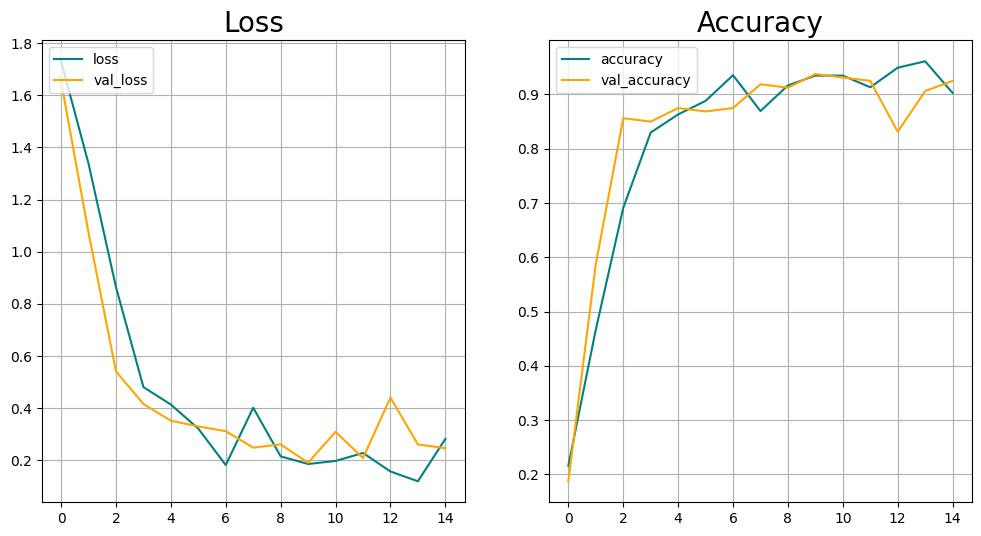

In [10]:
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

train_loss = training_history.history['loss']
val_loss = training_history.history['val_loss']

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss, color='teal', label='loss')
plt.plot(val_loss, color='orange', label='val_loss')
plt.grid(True)
plt.title('Loss', fontsize=20)
plt.legend(loc="upper left")

plt.subplot(1, 2, 2)
plt.plot(train_acc, color='teal', label='accuracy')
plt.plot(val_acc, color='orange', label='val_accuracy')
plt.grid(True)
plt.title('Accuracy', fontsize=20)
plt.legend(loc="upper left")

plt.show()

Inference

In [11]:
# Prediction function
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


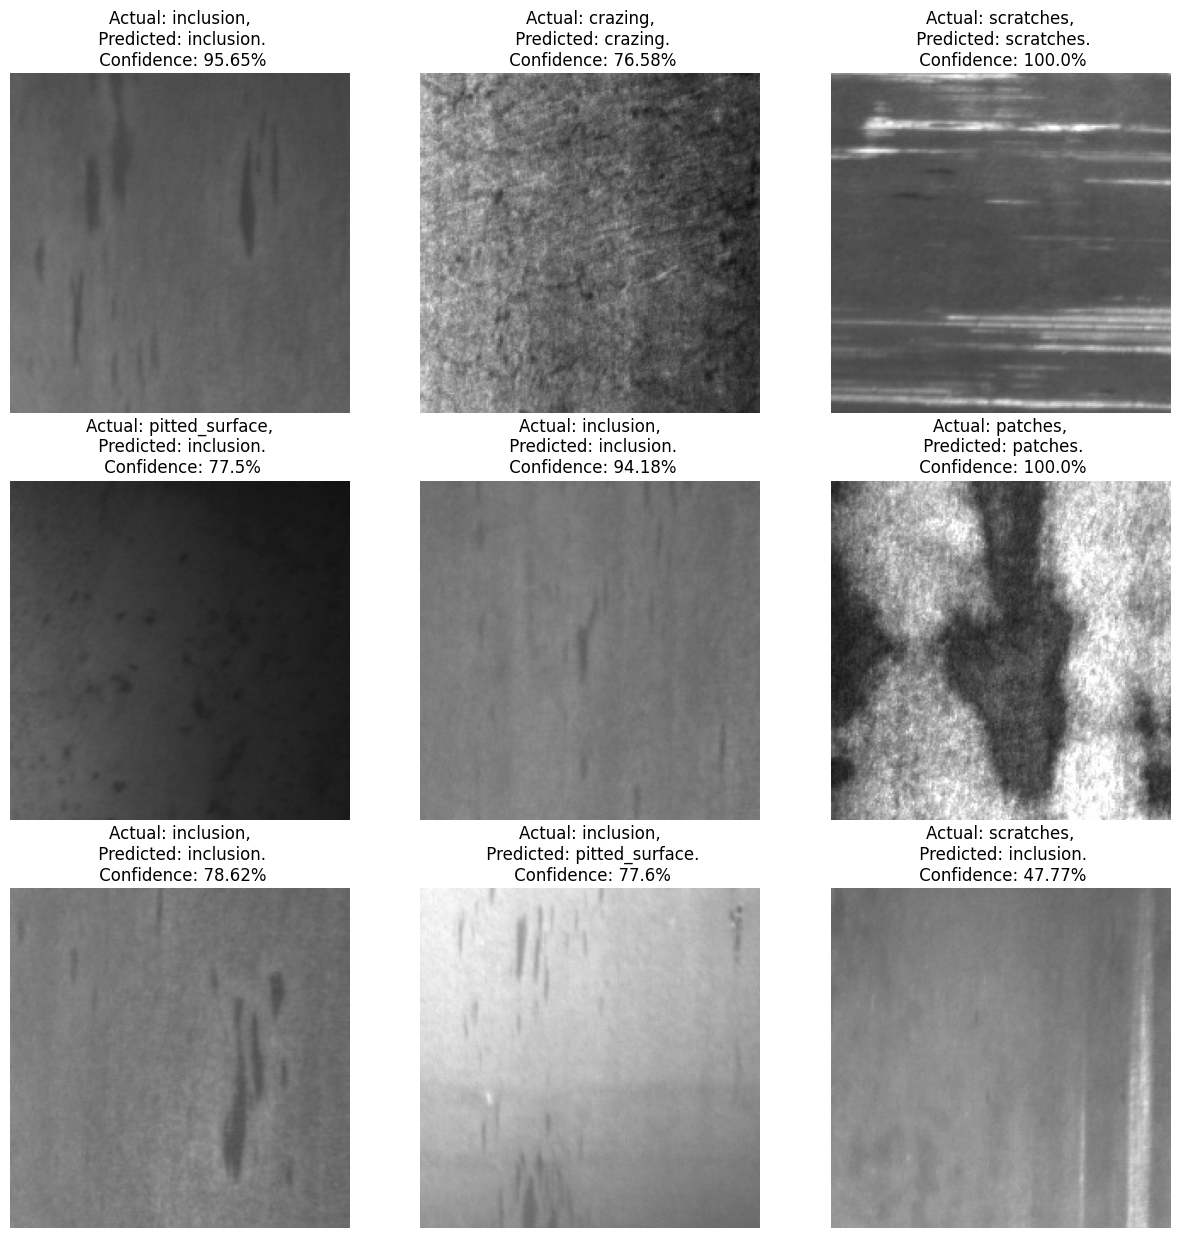

In [15]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Saving the Model

In [13]:
model_version=max([int(i) for i in os.listdir(r"models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1\assets


INFO:tensorflow:Assets written to: models/1\assets


In [14]:
# model.save("models/defect.h5")